<font size="6"><b>DeepDream</b></font>


---



#Importing the Necessary Libraries

In [ ]:
import os
from io import BytesIO
import numpy as np
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from functools import partial
import ipywidgets as widgets

#Unzipping the Model File

In [ ]:
#!unzip inception5h.zip
!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

--2023-07-01 19:33:47--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  77.3MB/s    in 0.6s    

2023-07-01 19:33:48 (77.3 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


#Importing Pre-trained Inception Model and Configuring the Graph

In [ ]:
model = 'tensorflow_inception_graph.pb'

graph = tf.Graph()
tf_session = tf.compat.v1.InteractiveSession(graph=graph)

with tf.io.gfile.GFile(model, 'rb') as f:
    graph_definition = tf.compat.v1.GraphDef()
    graph_definition.ParseFromString(f.read())

tensor_input = tf.compat.v1.placeholder(np.float32, name='input')
imagenet_mean = 200.0
tensor_preprocessed = tf.expand_dims(tensor_input - imagenet_mean, 0)

tf.compat.v1.import_graph_def(graph_definition, {'input': tensor_preprocessed})

This code section loads and sets up the Inception model in TensorFlow. It reads the model file "tensorflow_inception_graph.pb" and parses its contents to create a graph definition. It also defines a placeholder for input data and applies preprocessing to the input by subtracting the mean value. Finally, it imports the graph definition into the TensorFlow session for further usage.

#Counting Convolutional Layers and Feature Channels in the Inception Model*

In [ ]:
layers = []
feature_numbers = []

for op in graph.get_operations():
    if op.type == 'Conv2D' and 'import/' in op.name:
        layers.append(op.name)
        feature_numbers.append(int(graph.get_tensor_by_name(op.name + ':0').shape[-1]))

print('Total number of layers:', str(len(layers))+"\n")
print('Total number of feature channels:', sum(feature_numbers))

Total number of layers: 59

Total number of feature channels: 7548


This code section counts the number of convolutional layers and the total number of feature channels in the Inception model. It iterates through all the operations in the graph and checks for Conv2D operations with names containing "import/". It appends the names of these operations to the "layers" list and extracts the number of feature channels from the corresponding tensors.

# **Get Tensor by Layer Name**

In [ ]:
def Tensor(layer):
    return tf.compat.v1.get_default_graph().get_tensor_by_name(f"import/{layer}:0")

This code section defines a function named Tensor that is used to retrieve a specific tensor from the TensorFlow graph based on its layer name. The function takes the layer name as input and returns the corresponding tensor object.

#Showing layer name and channels number

In [ ]:
for i, layer in enumerate(layers):
    number_of_channels = graph.get_tensor_by_name(layer + ':0').shape[3]
    print("Layer name({}): {}".format(i, layer.split("/")[1]))
    print("Channels number: {}".format(number_of_channels))
    print()

Layer name(0): conv2d0_pre_relu
Channels number: 64

Layer name(1): conv2d1_pre_relu
Channels number: 64

Layer name(2): conv2d2_pre_relu
Channels number: 192

Layer name(3): mixed3a_1x1_pre_relu
Channels number: 64

Layer name(4): mixed3a_3x3_bottleneck_pre_relu
Channels number: 96

Layer name(5): mixed3a_3x3_pre_relu
Channels number: 128

Layer name(6): mixed3a_5x5_bottleneck_pre_relu
Channels number: 16

Layer name(7): mixed3a_5x5_pre_relu
Channels number: 32

Layer name(8): mixed3a_pool_reduce_pre_relu
Channels number: 32

Layer name(9): mixed3b_1x1_pre_relu
Channels number: 128

Layer name(10): mixed3b_3x3_bottleneck_pre_relu
Channels number: 128

Layer name(11): mixed3b_3x3_pre_relu
Channels number: 192

Layer name(12): mixed3b_5x5_bottleneck_pre_relu
Channels number: 32

Layer name(13): mixed3b_5x5_pre_relu
Channels number: 96

Layer name(14): mixed3b_pool_reduce_pre_relu
Channels number: 64

Layer name(15): mixed4a_1x1_pre_relu
Channels number: 192

Layer name(16): mixed4a_3x3_

#Extracting Layer Name from Graph Operation

In [ ]:
layer = layers[46]
print(layer + "\n")
layer = "/".join(layer.split("/")[1:-1])
print(layer)

import/mixed5a_3x3_bottleneck_pre_relu/conv

mixed5a_3x3_bottleneck_pre_relu


This code section extracts the layer name from a graph operation and processes it to obtain a cleaned layer name.

#Extracting Tensor from a Layer in the Inception Model

In [ ]:
Tensor(layer)

<tf.Tensor 'import/mixed5a_3x3_bottleneck_pre_relu:0' shape=(None, None, None, 160) dtype=float32>

This code section retrieves a specific tensor (layer) from the pre-trained Inception model.

#Initialization of Layer Name, Channel, and Noisy Image

In [ ]:
layer_name= 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139

noisy_image = np.random.uniform(size=(224,224,3)) + 100.0

This code section initializes the variables layer_name, channel, and noisy_image for further use in the deep learning visualization process. layer_name represents the specific layer of interest in the model. channel represents the channel index within that layer. noisy_image is a randomly generated image with shape (224, 224, 3) and pixel values randomly sampled from a uniform distribution between 100.0 and 200.0. These variables serve as inputs for the subsequent visualization functions.

#Naive DeepDream Image Generation

**Image Visualization and Normalization Functions**

In [ ]:
def show_image(image_array, fmt='jpeg'):
    image_array = np.clip(image_array, 0, 1)
    image_array = (image_array * 255).astype(np.uint8)
    img = PIL.Image.fromarray(image_array)
    f = BytesIO()
    img.save(f, format=fmt)

    display(Image(data=f.getvalue()))


def visual_normalization(image_array, scaling_factor=0.1):
    image_array_mean = np.mean(image_array)
    image_array_std = np.std(image_array)
    max_std = max(image_array_std, 1e-4)
    normalized = (image_array - image_array_mean) / max_std * scaling_factor + 0.5
    return normalized

This code section includes two functions for displaying images and normalizing image ranges for visualization purposes.

**Render Naive DeepDream Image**

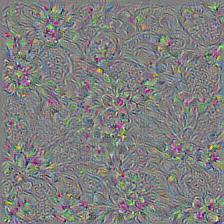

In [ ]:
def render_naive(target_tensor, input_image=noisy_image, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(target_tensor)
    t_grad = tf.gradients(t_score, tensor_input)[0]

    input_image = input_image.copy()
    show_image(visual_normalization(input_image))

    for i in range(iter_n):
        gradients, score = tf_session.run([t_grad, t_score], {tensor_input: input_image})
        gradients /= gradients.std() + 1e-8
        input_image += gradients * step
        clear_output()
        show_image(visual_normalization(input_image))

render_naive(Tensor(layer_name)[:,:,:,channel])

This code section defines a function render_naive that generates a DeepDream image using a naive optimization approach.

#Multi-scale DeepDream Image Generation

**TensorFlow Graph Transformation Helper**

In [ ]:
def tensorflow_function(*argtypes):
    def wrap(f):
        graph = tf.Graph()
        with graph.as_default():
            placeholders = [tf.placeholder(argtype) for argtype in argtypes]
            outputs = f(*placeholders)
            session = tf.Session()
            session.run(tf.global_variables_initializer())

        def wrapper(*args, **kwargs):
            feed_dict = {placeholder: arg for placeholder, arg in zip(placeholders, args)}
            return session.run(outputs, feed_dict=feed_dict)

        return wrapper

    return wrap

The code section defines a function wrapper called tffunc that facilitates the creation and execution of TensorFlow functions. This wrapper simplifies the process of defining TensorFlow operations by automatically handling graph creation, placeholder creation, and session initialization.

**Image Resize Function using TensorFlow**

In [ ]:
def resize(image, size):
    image = tf.expand_dims(image, 0)
    image.set_shape([1, None, None, None])
    return tf.image.resize(image, size, method=tf.image.ResizeMethod.BILINEAR)[0,:,:,:]

resize = tensorflow_function(np.float32, np.int32)(resize)

This code section defines a function called resize that resizes an input image tensor using TensorFlow. The function takes an image tensor img and a target size size as inputs. It expands the image tensor to have an extra dimension for the batch size, sets the shape of the tensor, and then uses TensorFlow's tf.image.resize function to resize the image to the specified size using the bilinear interpolation method.

**Tiled Gradient Calculation for Image Manipulation**

In [ ]:
def calculate_gradient_tiled(image, target_gradient, tile_size=512):
    sz = tile_size
    h, w = image.shape[:2]
    sx, sy = np.random.randint(sz, size=2)

    img_shift = np.roll(np.roll(image, sx, axis=1), sy, axis=0)

    gradient = np.zeros_like(image)

    for y in range(0, max(h - sz // 2, sz), sz):
        for x in range(0, max(w - sz // 2, sz), sz):
            sub = img_shift[y:y + sz, x:x + sz]
            g = tf_session.run(target_gradient, {tensor_input: sub})

            norm_factor = np.sqrt(np.mean(np.square(g))) + 1e-8
            g /= norm_factor

            gradient[y:y + sz, x:x + sz] = g

    gradient = np.roll(np.roll(gradient, -sx, axis=1), -sy, axis=0)
    return gradient

This code section defines a function called calc_grad_tiled that performs tiled gradient calculation on an input image. The function takes an image, a target gradient tensor (target_gradient), and an optional tile size as parameters.

**Multi-scale DeepDream Rendering**

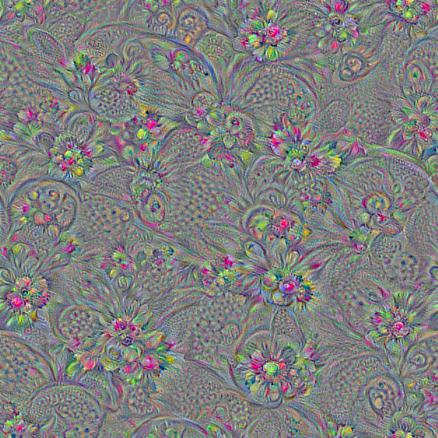

In [ ]:
def render_multiscale(target_tensor, input_image=noisy_image, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(target_tensor)
    t_grad = tf.gradients(t_score, tensor_input)[0]

    input_image = input_image.copy()
    for octave in range(octave_n):
        if octave > 0:
            hw = np.float32(input_image.shape[:2]) * octave_scale
            input_image = resize(input_image, np.int32(hw))
        for i in range(iter_n):
            gradients = calculate_gradient_tiled(input_image, t_grad)
            gradients /= (np.std(gradients) + 1e-8)
            input_image += gradients * step
            print('.', end=' ')
            clear_output()
            show_image(visual_normalization(input_image))

render_multiscale(Tensor(layer_name)[:,:,:,channel])

The render_multiscale function performs multi-scale DeepDream rendering on an input image using a specified target layer and channel. It iteratively applies gradient ascent to enhance the patterns and features found in the specified layer and channel of the image. The function progressively scales up the image in multiple octaves and applies the gradient ascent optimization at each octave.

#Laplacian Pyramid Gradient Normalized Image Generation


**Image Splitting into Low and High Frequency Components**

In [ ]:
def  laplacian_splitting(image):
    kernel = np.float32([1, 4, 6, 4, 1])
    kernel = np.outer(kernel, kernel)
    kernel = kernel[:, :, None, None] / np.sum(kernel) * np.eye(3, dtype=np.float32)

    with tf.name_scope('split'):
        lo = tf.nn.conv2d(image, kernel, [1, 2, 2, 1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, kernel * 4, tf.shape(image), [1, 2, 2, 1])
        hi = image - lo2
    return lo, hi

The code section defines a function laplacian_splitting that takes an image as input and splits it into two components: low frequency (lo) and high frequency (hi). The function achieves this by applying a convolution operation with a specific kernel to the image.

**Laplacian Pyramid Construction with N Splits**

In [ ]:
def laplacian_splitting_n(image, n):
    levels = []
    for _ in range(n):
        image, hi = laplacian_splitting(image)
        levels.append(hi)
    levels.append(image)
    return levels[::-1]

The code section defines a function laplacian_splitting_n that constructs a Laplacian pyramid with n splits. The Laplacian pyramid is a multi-scale representation of an image that captures details at different levels of resolution.

**Laplacian Pyramid Merge**

In [ ]:
def laplacian_merge(levels):
    image = levels[0]
    kernel = np.float32([1, 4, 6, 4, 1])
    kernel = np.outer(kernel, kernel)
    kernel = kernel[:, :, None, None] / np.sum(kernel) * np.eye(3, dtype=np.float32)

    for hi in levels[1:]:
        with tf.name_scope('merge'):
            image = tf.nn.conv2d_transpose(image, kernel * 4, tf.shape(hi), [1, 2, 2, 1]) + hi
    return image

This code section defines a function called laplacian_merge that merges the levels of a Laplacian pyramid.

**Image Standardization Function**

In [ ]:
def normalize_std(image, eps=1e-10):
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(image)))
        return image / tf.maximum(std, eps)

The normalize_std function normalizes an image by making its standard deviation equal to 1.0. It takes an image tensor as input and calculates the standard deviation of the image pixels.

**Laplacian Pyramid Normalization**

In [ ]:
def laplacian_normalize(image, scale_n=4):
    image = tf.expand_dims(image, 0)
    tlevels = laplacian_splitting_n(image, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = laplacian_merge(tlevels)
    return out[0, :, :, :]

**Example Usage**

In [ ]:
with tf.Graph().as_default():
    laplacian_input = tf.placeholder(np.float32, name='laplacian_input')
    laplacian_output = laplacian_normalize(laplacian_input)

This code section demonstrates the implementation of Laplacian normalization in TensorFlow. It creates a new TensorFlow graph, defines a placeholder tensor for Laplacian input, and applies the laplacian_normalize function to normalize the input.

**Image Rendering with Laplacian Normalization**

In [ ]:
def render_laplacian_normalization(target_tensor, input_image= noisy_image, visual_normalization=visual_normalization,
                   iter_n=10, step=1.0, octave_n=4, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(target_tensor)
    t_grad = tf.gradients(t_score, tensor_input)[0]

    lap_norm_func = tensorflow_function(np.float32)(partial(laplacian_normalize, scale_n=lap_n))

    input_image = input_image.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(input_image.shape[:2])*octave_scale
            input_image = resize(input_image, np.int32(hw))
        for i in range(iter_n):
            g = calculate_gradient_tiled(input_image, t_grad)
            g = lap_norm_func(g)
            input_image += g*step
            print('.', end = ' ')
        clear_output()
        show_image(visual_normalization(input_image))

This code section defines a function render_lapnorm that performs image rendering using Laplacian normalization for optimization.

**Playing with feature visualizations**

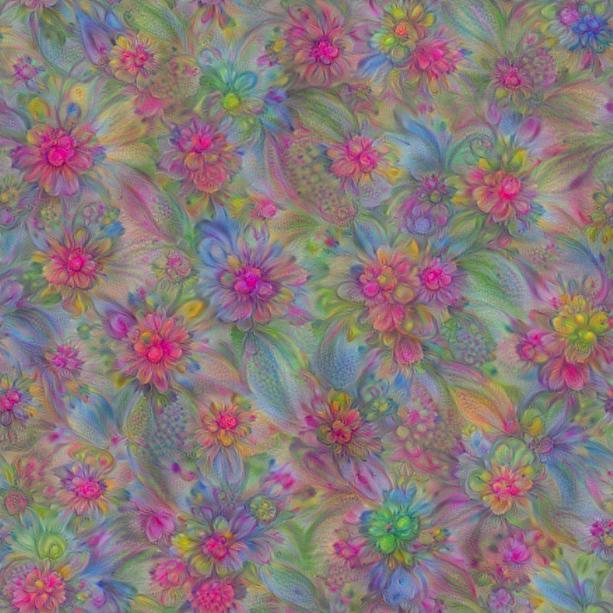

In [ ]:
render_laplacian_normalization(Tensor(layer_name)[:,:,:,channel])

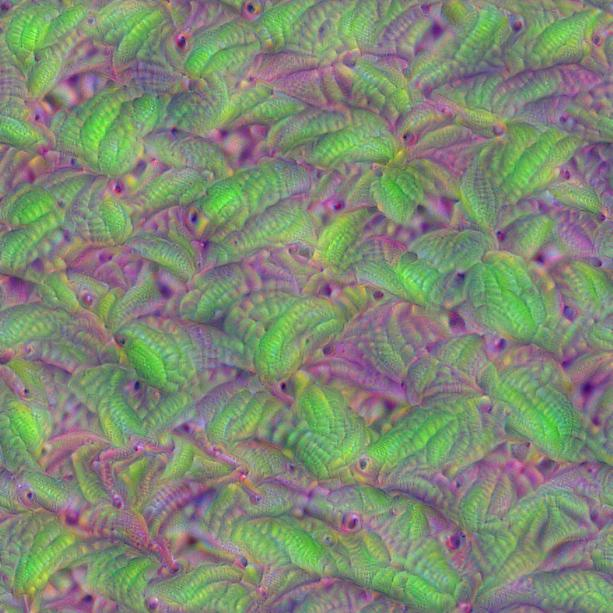

In [ ]:
render_laplacian_normalization(Tensor(layer_name)[:,:,:,121])

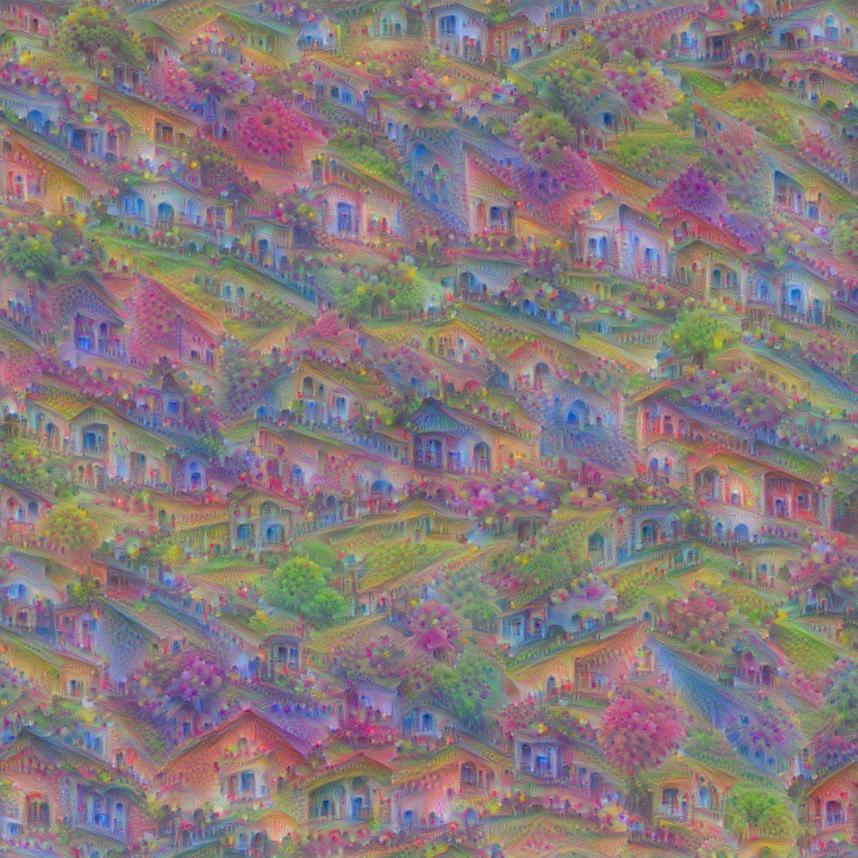

In [ ]:
render_laplacian_normalization(Tensor(layer_name)[:,:,:,65]+Tensor(layer_name)[:,:,:,139], octave_n=5)

#DeepDream Algorithm Implementation


In [ ]:
def deepdream(target_tensor, image= noisy_image,
                     iter_n=8, step=2.0, octave_n=7, octave_scale=1.15):
    t_score = tf.reduce_mean(target_tensor)
    t_grad = tf.gradients(t_score, tensor_input)[0]

    octaves = []
    for i in range(octave_n-1):
        hw = image.shape[:2]
        lo = resize(image, np.int32(np.float32(hw)/octave_scale))
        hi = image-resize(lo, hw)
        image = lo
        octaves.append(hi)

    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            image = resize(image, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calculate_gradient_tiled(image, t_grad)
            image += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
            #clear_output()
            show_image(image/255.0)

This code section implements the DeepDream image rendering algorithm, which generates visually intriguing and surreal images by optimizing the activations of a given layer in a pre-trained neural network. The algorithm enhances patterns and features in the input image by iteratively modifying it based on the gradients of a chosen optimization objective.

##Image Loading and Display

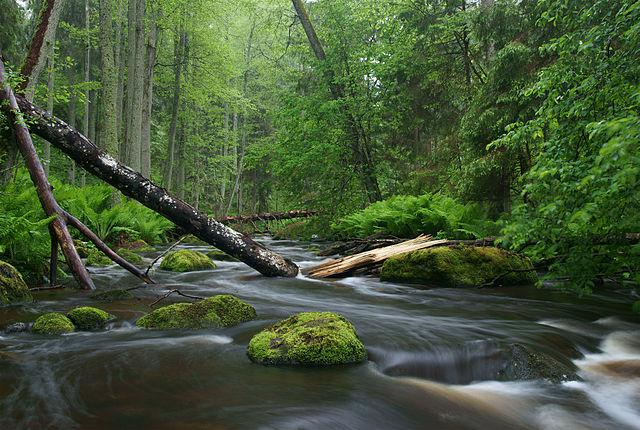

In [ ]:
image = PIL.Image.open('/content/640px-Altja_jõgi_Lahemaal.jpg')
image = np.float32(image)
show_image(image/255.0)

##Style Selection Dropdown for Image Styling

In [ ]:
style_options = {
    'Select a Style': "",
    'Style 1': Tensor(layer_name)[:,:,:,0]+Tensor(layer_name)[:,:,:,139]+Tensor(layer_name)[:,:,:,115],
    'Style 2': Tensor(layer_name)[:,:,:,1]+Tensor(layer_name)[:,:,:,139],
    'Style 3': Tensor(layer_name)[:,:,:,65],
    'Style 4': Tensor(layer_name)[:,:,:,67]+Tensor(layer_name)[:,:,:,68]+Tensor(layer_name)[:,:,:,139],
    'Style 5': Tensor(layer_name)[:,:,:,68],
    'Style 6': Tensor(layer_name)[:,:,:,70],
    'Style 7': Tensor(layer_name)[:,:,:,113],
    'Style 8': Tensor(layer_name)[:,:,:,114],
    'Style 9': Tensor(layer_name)[:,:,:,115],
    'Style 10': Tensor(layer_name)[:,:,:,117],
    'Style 11': Tensor(layer_name)[:,:,:,121],
    'Style 12': Tensor(layer_name)[:,:,:,129],
    'Style 13': Tensor(layer_name)[:,:,:,135],
    'Style 14': Tensor(layer_name)[:,:,:,137],
    'Style 15': Tensor(layer_name)[:,:,:,138],
    'Style 16': Tensor(layer_name)[:,:,:,139],
    'Style 17': Tensor(layer_name)[:,:,:,1]+Tensor(layer_name)[:,:,:,13]
}

dropdown = widgets.Dropdown(options=style_options, description='Select Style')

def select_style(change):
    global style
    style = change.new

dropdown.observe(select_style, names='value')

display(dropdown)

Dropdown(description='Select Style', options={'Select a Style': '', 'Style 1': <tf.Tensor 'add_1:0' shape=(Non…

##Generate DeepDream Image

In [ ]:
deepdream(style, image)

Output hidden; open in https://colab.research.google.com to view.